In [1]:
import hmftpy as hmf
import numpy as np
import matplotlib.pyplot as plt
from hmftpy.plaquettes.square import plaq4
from hmftpy.plaquettes.triangular import plaq3, plaq12
from quspin.basis import spin_basis_1d
from quspin.operators import quantum_operator
from tqdm import tqdm

In [2]:
b3 = spin_basis_1d(3, pauli=0)
b12 = spin_basis_1d(12, pauli=0)

# Hamiltonian
Here, we consider the DM interaction
\begin{align*}
    H = &\sum_{\langle i, j\rangle} \vec D_{ij} \cdot \left(\vec \sigma_i \times\vec \sigma_j\right)
        + \sum_{\langle i, j\rangle} J_{ij} \vec \sigma_i \cdot \vec \sigma_j
        + B \sum_i \sigma_i^z.
\end{align*}
In [this paper](https://arxiv.org/abs/2004.13526),
they set $J_{ij}$ being isotropic, so let's set $J_{ij} = J \forall i, j$.

They say $\vec D_{ij}$ points in-plane and perpendicular to the bond between $i$ and $j$. I'm not 100% sure what they mean by this, but it seems like I want three versions of the vector $\vec D_{ij}$ depending on whether $i$ and $j$ are linked horizontally or by one of two diagonal directions. In my code, I (somewhat confusingly) call these $x$, $y$, and $z$ bonds.

To illustrate what my bond directions are, consider the three sites below:

      2
     / \
    0 - 1
    
In my plaquette definitions, I call the bond from 0 to 1 an `x_bond`, the bond from 1 to 2 a `y_bond`, and the bond from 2 to 0 a `z_bond`.

In the X-Y plane, the `x_bond` corresponds to the unit vector $[1,0]$, 
the `y_bond` corresponds to $\left[-\frac{1}{2}, \frac{\sqrt 3}{2}\right]$,
and the `z_bond` is $\left[\frac{1}{2}, \frac{\sqrt 3}{2}\right]$.

Then, I think I can set $\vec D^x = [0,1,0]$,
$\vec D^y = \left[\frac{\sqrt 3}{2}, \frac{1}{2}, 0\right]$,
and $\vec D^z = \left[\frac{\sqrt 3}{2}, -\frac{1}{2}, 0\right]$.

In [3]:
J = -0.5
D = {'x': np.array([0., 1., 0.]),
     'y': np.array([0.5*np.sqrt(3), 0.5, 0]),
     'z': np.array([0.5*np.sqrt(3), -0.5, 0])}
B = -.8

interactions = {'{}_bonds'.format(d): 
                    {'xx': J, 'yy': J, 'zz': J,
                     'yz': D[d][0], 'zy': -D[d][0],
                     'zx': D[d][1], 'xz': -D[d][1],
                     'xy': D[d][2], 'yx': -D[d][2]}
                for d in ['x', 'y', 'z']}
interactions['local'] = {'z': B}
print('X bond direction')
print(interactions['x_bonds'])
print('Y bond direction')
print(interactions['y_bonds'])
print('Z bond direction')
print(interactions['z_bonds'])
print('One-spin interactions')
print(interactions['local'])

X bond direction
{'xx': -0.5, 'yy': -0.5, 'zz': -0.5, 'yz': 0.0, 'zy': -0.0, 'zx': 1.0, 'xz': -1.0, 'xy': 0.0, 'yx': -0.0}
Y bond direction
{'xx': -0.5, 'yy': -0.5, 'zz': -0.5, 'yz': 0.8660254037844386, 'zy': -0.8660254037844386, 'zx': 0.5, 'xz': -0.5, 'xy': 0.0, 'yx': -0.0}
Z bond direction
{'xx': -0.5, 'yy': -0.5, 'zz': -0.5, 'yz': 0.8660254037844386, 'zy': -0.8660254037844386, 'zx': -0.5, 'xz': 0.5, 'xy': 0.0, 'yx': -0.0}
One-spin interactions
{'z': -0.8}


To fix this inconsistency, I added an additional way of forming Hamiltonians. For some clusters, I have added lists of nearest neighbor bonds with some consistently-chosen direction (counter-clockwise in upright triangles in these cases). This seems to give equivalent results to the previous case (skipping every-other bond)

In [4]:
Hi = hmf.operators.inner_hamiltonian(plaq3, interactions, b3, checks=False)
e, v = Hi.eigsh(k=1, which='SA')
ei = e[0]
Hp = hmf.operators.periodic_hamiltonian(plaq3, interactions, b3, checks=False)
e, v = Hp.eigsh(k=1, which='SA')
ep = e[0]
print('ED energy with OBC: {}'.format(ei))
print('ED energy with PBC: {}'.format(ep))

e_hmft, v, mf, cvg = hmf.do_hmft(plaq3, interactions, b3)

print('HMFT energy: {}'.format(e_hmft))
print('HMFT converged? {}'.format(cvg))

ED energy with OBC: -1.7730653136568657
ED energy with PBC: -2.5192218087303657
HMFT energy: -2.485870370645122
HMFT converged? True


Let's look at observables as we change $B$. Specifically, let's measure scalar chirality
$\chi = \sigma_0 \cdot \left(\sigma_1 \times \sigma_2\right)$ and magnetization $M_z = \sum_i \sigma_i^z$.

In [5]:
Mz = quantum_operator({'static': [['z', [[1./3, i] for i in range(3)]]]}, basis=b3, check_herm=False, check_symm=False)
chi = quantum_operator({'static': [['xyz', [[1,0,1,2]]],
                                   ['xzy', [[-1,0,1,2]]],
                                   ['yzx', [[1,0,1,2]]],
                                   ['yxz', [[-1,0,1,2]]],
                                   ['zxy', [[1,0,1,2]]],
                                   ['zyx', [[-1,0,1,2]]]]}, basis=b3,
                      check_herm=False, check_symm=False)
steps = 50
chis_hmft = np.zeros(steps)
chis_pbc = np.zeros(steps)
ms_hmft = np.zeros(steps)
ms_pbc = np.zeros(steps)
es_hmft = np.zeros(steps)
es_pbc = np.zeros(steps)

Bs = np.linspace(0, 1, steps)
mf = None
for i, B in enumerate(Bs):
    interactions['local'] = {'z': B}
    
    Hp = hmf.operators.periodic_hamiltonian(plaq3, interactions, b3, checks=False)
    es_pbc[i], v = Hp.eigsh(k=1, which='SA')
    v_pbc = v[:,0]
    chis_pbc[i] = chi.expt_value(v_pbc).real
    ms_pbc[i] = Mz.expt_value(v_pbc).real
    
    es_hmft[i], v_hmft, mf, cvg = hmf.do_hmft(plaq3, interactions, b3, mf0=mf)
    chis_hmft[i] = chi.expt_value(v_hmft).real
    ms_hmft[i] = Mz.expt_value(v_hmft).real

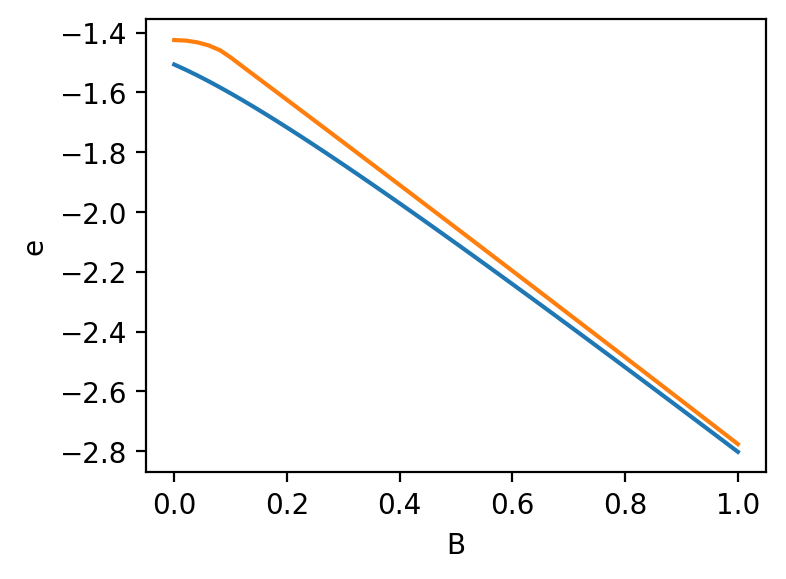

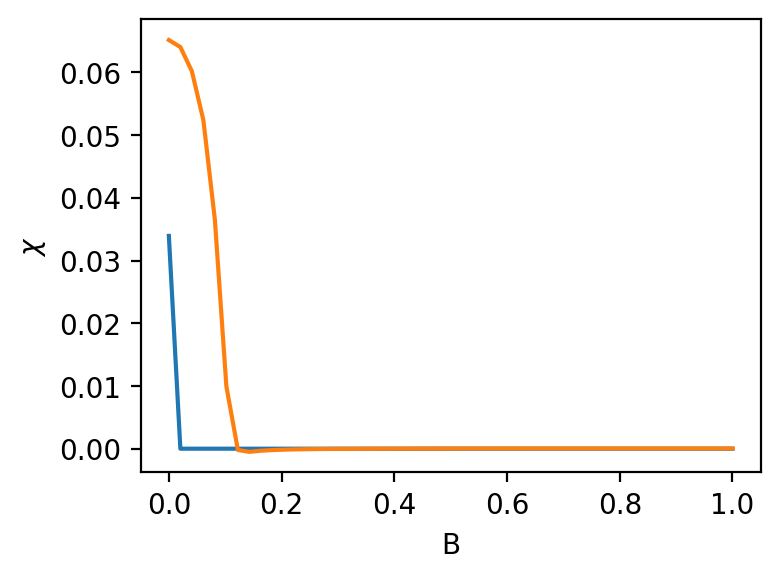

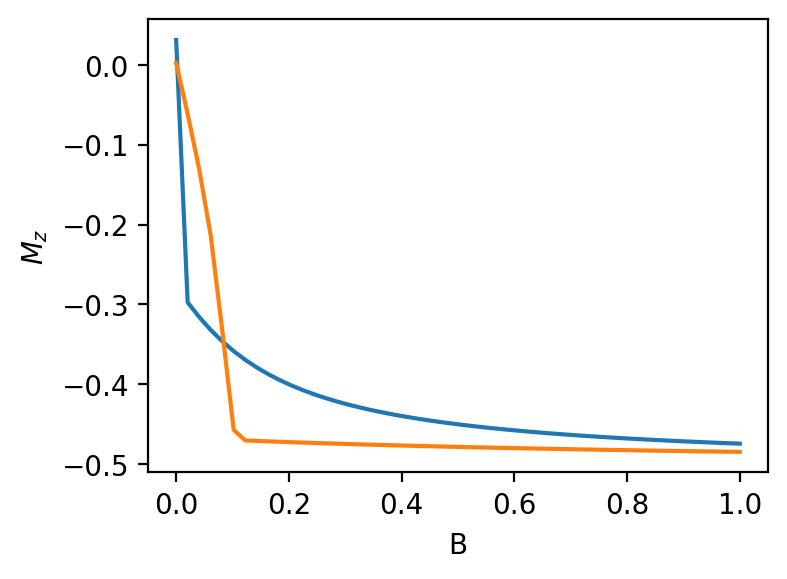

In [6]:
plt.figure(figsize=(4,3), dpi=200)
plt.plot(Bs, es_pbc)
plt.plot(Bs, es_hmft)
plt.xlabel('B')
plt.ylabel('e')
plt.show()

plt.figure(figsize=(4,3), dpi=200)
plt.plot(Bs, chis_pbc)
plt.plot(Bs, chis_hmft)
plt.xlabel('B')
plt.ylabel(r'$\chi$')
plt.show()

plt.figure(figsize=(4,3), dpi=200)
plt.plot(Bs, ms_pbc)
plt.plot(Bs, ms_hmft)
plt.xlabel('B')
plt.ylabel(r'$M_z$')
plt.show()

# 12 site

Now, let's apply this to a larger (12-site) cluster:

In [9]:
Mz = quantum_operator({'static': [['z', [[1./12, i] for i in range(12)]]]}, basis=b12, 
                      check_herm=False, check_symm=False)
tri_sites = [4,5,8]
chi = quantum_operator({'static': [['xyz', [[1,*tri_sites]]],
                                   ['xzy', [[-1,*tri_sites]]],
                                   ['yzx', [[1,*tri_sites]]],
                                   ['yxz', [[-1,*tri_sites]]],
                                   ['zxy', [[1,*tri_sites]]],
                                   ['zyx', [[-1,*tri_sites]]]]}, 
                       basis=b12, check_herm=False, check_symm=False)
steps = 20
chis_hmft = np.zeros(steps)
chis_pbc = np.zeros(steps)
ms_hmft = np.zeros(steps)
ms_pbc = np.zeros(steps)
es_hmft = np.zeros(steps)
es_pbc = np.zeros(steps)

Bs = np.linspace(0, 1, 20)
mf = None
for i, B in enumerate(Bs):
    interactions['local'] = {'z': B}
    
    Hp = hmf.operators.periodic_hamiltonian(plaq12, interactions, b12, checks=False)
    es_pbc[i], v = Hp.eigsh(k=1, which='SA')
    v_pbc = v[:,0]
    chis_pbc[i] = chi.expt_value(v_pbc).real
    ms_pbc[i] = Mz.expt_value(v_pbc).real
    
    es_hmft[i], v_hmft, mf, cvg = hmf.do_hmft(plaq12, interactions, b12, mf0=mf)
    chis_hmft[i] = chi.expt_value(v_hmft).real
    ms_hmft[i] = Mz.expt_value(v_hmft).real

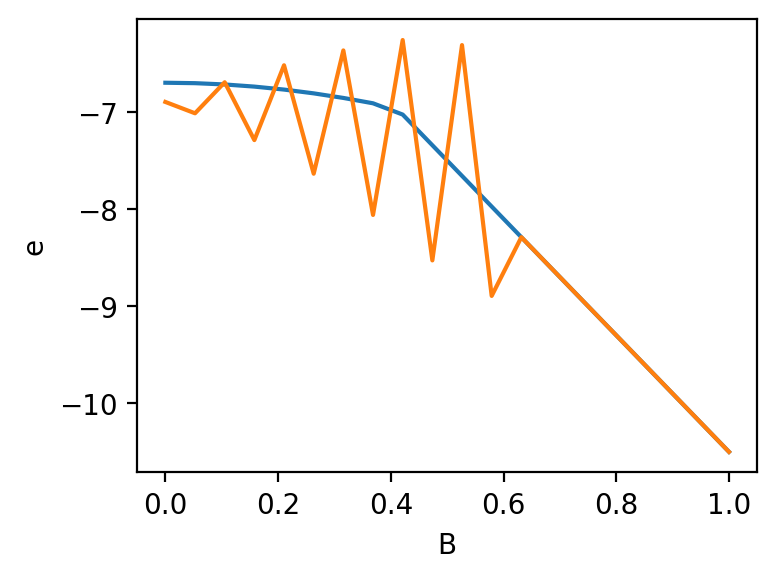

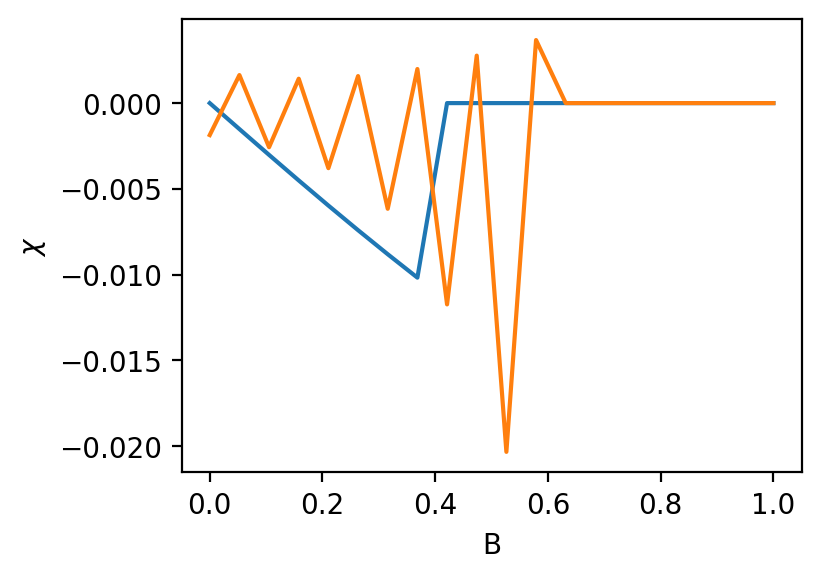

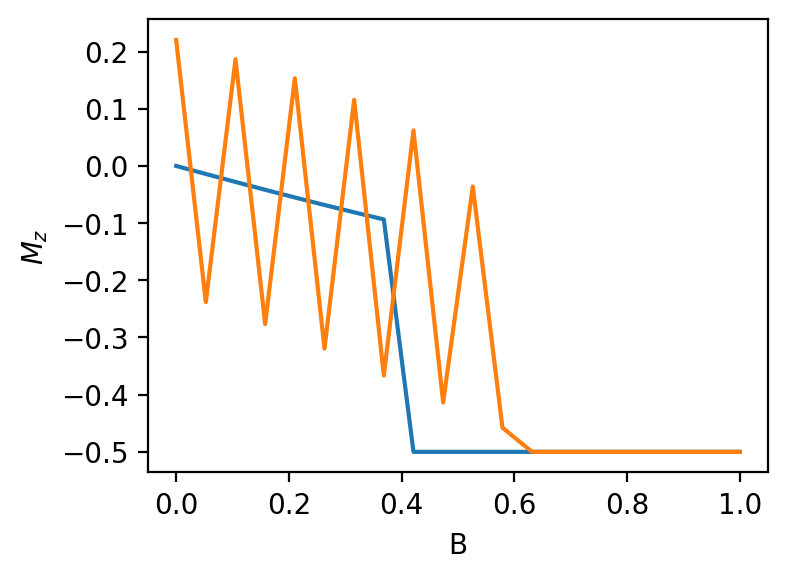

In [10]:
plt.figure(figsize=(4,3), dpi=200)
plt.plot(Bs, es_pbc)
plt.plot(Bs, es_hmft)
plt.xlabel('B')
plt.ylabel('e')
plt.show()

plt.figure(figsize=(4,3), dpi=200)
plt.plot(Bs, chis_pbc)
plt.plot(Bs, chis_hmft)
plt.xlabel('B')
plt.ylabel(r'$\chi$')
plt.show()

plt.figure(figsize=(4,3), dpi=200)
plt.plot(Bs, ms_pbc)
plt.plot(Bs, ms_hmft)
plt.xlabel('B')
plt.ylabel(r'$M_z$')
plt.show()